# Практическая работа №6: Кластерный анализ. Метод k-средних

Выполнил студент гр. 1384 Степаненко Денис Владиславович.

## Цель работы

Освоение основных понятий и некоторых методов кластерного анализа, в частности, метода k-средних.

## Основные теоретические положения

Нормализация данных через среднне выборочное и СКО:

$ \hat{x} = \frac{x - \bar{x}}{S_x} $

Метрики качества кластерезации:

1) $F_1$ — сумма квадратов расстояний от точек до центроидов их кластеров:

$$ F_1 = \sum_{k=1}^{K} \sum_{j=1}^{N_k} d^2(X_i^{(k)}, \bar{X_j}^{(k)}) $$

2) $F_2$ — сумма внутрикластерных расстояний между точками:

$$ F_2 = \sum_{k=1}^{K} \sum_{X_i, K_j \in S_k} d^2(X_i,X_j) $$

3) $F_3$ — сумма внутрикластерных дисперсий:

$$ F_3 = \sum_{k=1}^{K} \sum_{j=1}^{N_k} \sigma _{kj}^2,$$

где $\sigma _{kj}^2$ - дисперсия j-й переменной в k-ом кластере.

В лабороторной в качетсве функции расстояния используется евклидово расстояние:

$$d\left( p,q \right)   = \sqrt{ \sum _{i=1}^{n}  \left( q_{i} - p_{i} \right)^2}$$





## Постановка задачи

Дано конечное множество из объектов, представленных двумя признаками (в качестве этого множества принимаем исходную двумерную выборку, сформированную ранее в практической работе №4). Выполнить разбиение исходного множества объектов на конечное число подмножеств (кластеров) с использованием метода k-means. Полученные результаты содержательно проинтерпретировать.

## Выполнение работы

## Пункт 1.
Нормализовать множество точек из предыдущего раздела, отобразить полученное множество.


In [1]:
import numpy as np
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/MyDrive/obesity_data.csv")
data = np.array(df)
# df

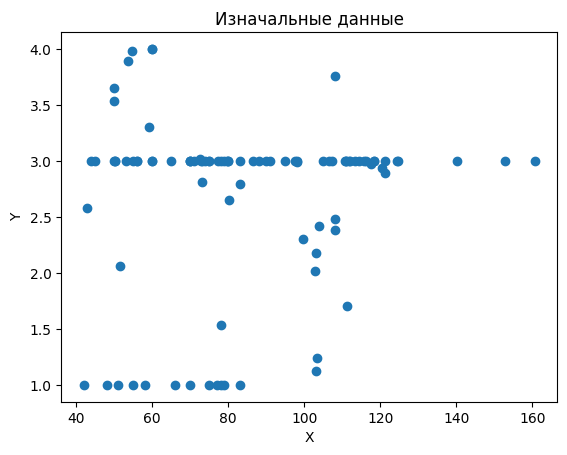

In [7]:
import matplotlib.pyplot as plt
plt.scatter(df.Weight, df.NCP)
plt.title("Изначальные данные")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

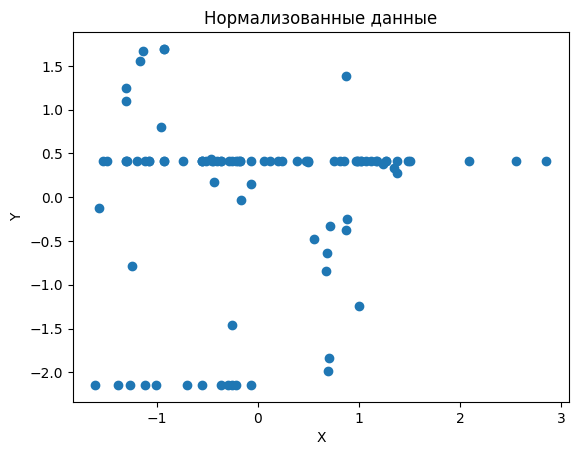

In [9]:
norm_values = (data - data.mean(axis=0)) / data.std(axis=0)

plt.scatter(norm_values[:, 0], norm_values[:, 1])
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Нормализованные данные")
plt.show()

### Пункт 2
Определить «грубую» верхнюю оценку количества кластеров: $\tilde k = \lfloor\sqrt{N/2}\rfloor$, где N – число точек.

In [28]:
N = len(df)
print("Число точкек:", N)

tilde_k = int(np.floor(np.sqrt(N/2)))
print("Грубая верхняя оценка количества кластеров:", tilde_k)

Число точкек: 95
Грубая верхняя оценка количества кластеров: 6


### Пункт 3.
Реализовать алгоритм k-means в двух вариантах:

а) пересчет центра кластера осуществляется после каждого изменения его состава;

б) пересчет центра кластера осуществляется лишь после того, как будет завершен просмотр всех данных (шаг процедуры).

In [115]:
def compute_distances(X, k, centroids):
    distances = np.zeros((X.shape[0], k))
    for i, centroid in enumerate(centroids):
        distances[:, i] = np.linalg.norm(X - centroid, axis=1)
    return distances

def k_means_1(X, k, max_iter=100, tol=0.001):
    """
    K-means с пересчетом центроидов после завершения просмотра всех данных.
    """
    metrics_history = []

    # Инициализация центроидов случайным образом
    random_indices = np.random.choice(X.shape[0], k, replace=False)
    centroids = X[random_indices].copy()

    for iteration in range(max_iter):
        old_centroids = centroids.copy()

        # Назначение каждой точки ближайшему центроиду
        distances = np.array([np.linalg.norm(X - centroid, axis=1) for centroid in centroids])
        labels = np.argmin(distances, axis=0)

        # Пересчет центроидов как среднее значение точек в каждом кластере
        new_centroids = np.array([X[labels == j].mean(axis=0) for j in range(k)])

        # Проверка сходимости
        if np.all(np.abs(new_centroids - centroids) < tol):
            print(f"Сходимость достигнута на итерации {iteration + 1}")
            centroids = new_centroids
            break

        centroids = new_centroids

        # Вычисление функционалов качества
        F1, F2, F3 = compute_quality_metrics(X, labels, centroids)
        metrics_history.append([F1, F2, F3])
        print(f"Итерация {iteration + 1}: F1={F1:.2f}, F2={F2:.2f}, F3={F3:.2f}")

    return labels, centroids, metrics_history



def k_means_2(X, k, max_iter=100, tol=0.001):
    """
    K-means с пересчетом центроидов после каждого изменения состава кластера.
    """
    metrics_history = []
    # Инициализация центроидов случайным образом
    random_indices = np.random.choice(X.shape[0], k, replace=False)
    centroids = X[random_indices].copy()
    labels = np.zeros(X.shape[0], dtype=int)

    for iteration in range(max_iter):
        old_centroids = centroids.copy()

        # Обработка каждой точки
        for i, point in enumerate(X):
            # Вычисление расстояний до центроидов
            distances = np.linalg.norm(centroids - point, axis=1)
            new_label = np.argmin(distances)

            if labels[i] != new_label:
                # Обновление метки точки
                labels[i] = new_label

                # Пересчет центроидов
                new_centroids = []
                for j in range(k):
                    cluster_points = X[labels == j]
                    if len(cluster_points) > 0:
                        new_centroids.append(cluster_points.mean(axis=0))
                    else:
                        # Если кластер пуст, сохраняем старый центроид
                        new_centroids.append(centroids[j])
                centroids = np.array(new_centroids)

        # Проверка сходимости
        if np.all(np.abs(centroids - old_centroids) < tol):
            print(f"Сходимость достигнута на итерации {iteration + 1}")
            break

        # Вычисление функционалов качества
        F1, F2, F3 = compute_quality_metrics(X, labels, centroids)
        metrics_history.append([F1, F2, F3])
        print(f"Итерация {iteration + 1}: F1={F1:.2f}, F2={F2:.2f}, F3={F3:.2f}")

    return labels, centroids, metrics_history


labels_1, centroids_1, metrics_history_1 = k_means_1(norm_values, tilde_k)

labels_2, centroids_2, metrics_history_2 = k_means_2(norm_values, tilde_k)

Итерация 1: F1=32.42, F2=835.96, F3=32.42
Итерация 2: F1=24.09, F2=501.38, F3=24.09
Итерация 3: F1=23.30, F2=466.59, F3=23.30
Итерация 4: F1=22.90, F2=447.91, F3=22.90
Итерация 5: F1=22.76, F2=451.89, F3=22.76
Итерация 6: F1=22.58, F2=465.18, F3=22.58
Итерация 7: F1=22.30, F2=455.50, F3=22.30
Итерация 8: F1=21.91, F2=473.28, F3=21.91
Итерация 9: F1=21.23, F2=498.11, F3=21.23
Сходимость достигнута на итерации 10
Итерация 1: F1=25.42, F2=467.22, F3=25.42
Итерация 2: F1=22.96, F2=433.28, F3=22.96
Итерация 3: F1=22.15, F2=468.85, F3=22.15
Итерация 4: F1=21.57, F2=472.18, F3=21.57
Сходимость достигнута на итерации 5


### Пункт 4.

На каждом шаге процедуры разбиения методом k-means вычислять функционалы качества полученного разбиения:

$F_1$ – сумма по всем кластерам квадратов расстояний элементов кластеров до центров соответствующих кластеров;

$F_2$ – сумма по всем кластерам внутрикластерных расстояний между элементами кластеров;

$F_3$ – сумма по всем кластерам внутрикластерных дисперсий (относительно центров кластеров).

In [116]:
def compute_quality_metrics(X, labels, centroids):
    F1 = 0  # Сумма квадратов расстояний до центров кластеров
    F2 = 0  # Сумма внутрикластерных расстояний между элементами
    F3 = 0  # Сумма внутрикластерных дисперсий

    for j in range(len(centroids)):
        cluster_points = X[labels == j]
        if len(cluster_points) > 0:
            F1 += np.sum(np.linalg.norm(cluster_points - centroids[j], axis=1)**2)

            pairwise_distances = np.linalg.norm(cluster_points[:, None] - cluster_points, axis=2)
            F2 += np.sum(pairwise_distances) / 2

            F3 += np.var(cluster_points, axis=0).sum() * len(cluster_points)

    return F1, F2, F3

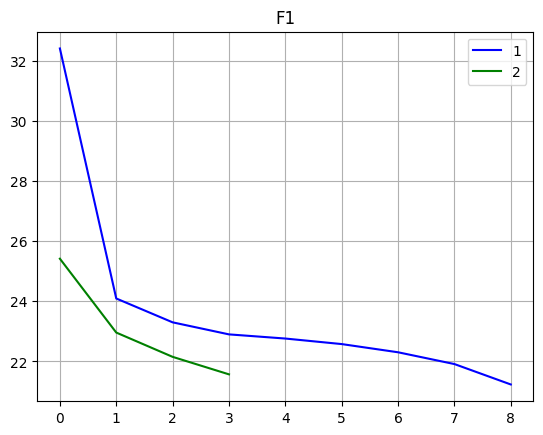

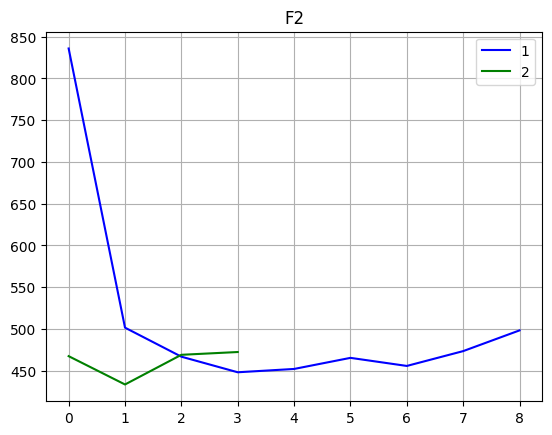

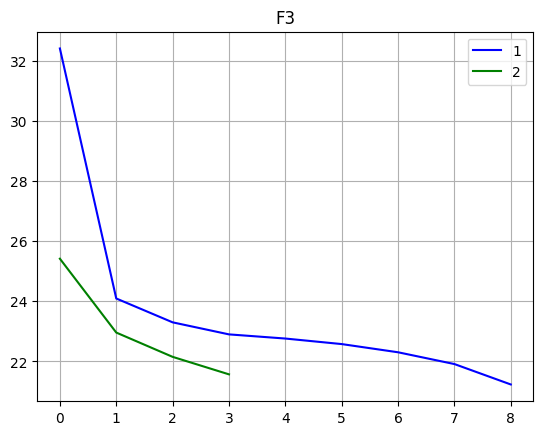

In [120]:
metrics_history_1 = np.array(metrics_history_1)
metrics_history_2 = np.array(metrics_history_2)


plt.grid()
plt.title('F1')
plt.plot(metrics_history_1[:,0], c='b', label="1")
plt.plot(metrics_history_2[:,0], c='g', label="2")
plt.legend()
plt.show()

plt.grid()
plt.title('F2')
plt.plot(metrics_history_1[:,1], c='b', label="1")
plt.plot(metrics_history_2[:,1], c='g', label="2")
plt.legend()
plt.show()


plt.grid()
plt.title('F3')
plt.plot(metrics_history_1[:,2], c='b', label="1")
plt.plot(metrics_history_2[:,2], c='g', label="2")
plt.legend()
plt.show()

### Пункт 5.
Отобразить полученные кластеры, выделить каждый кластер разным цветом, отметить центроиды.

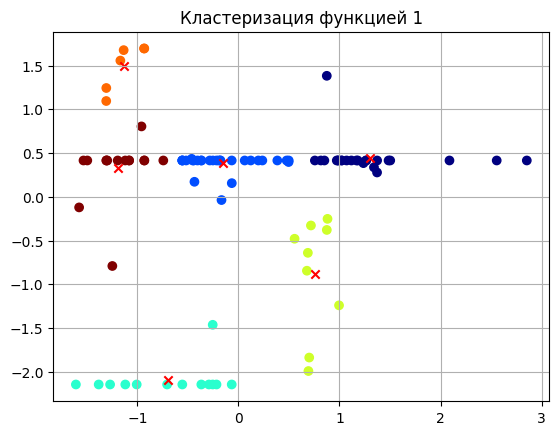

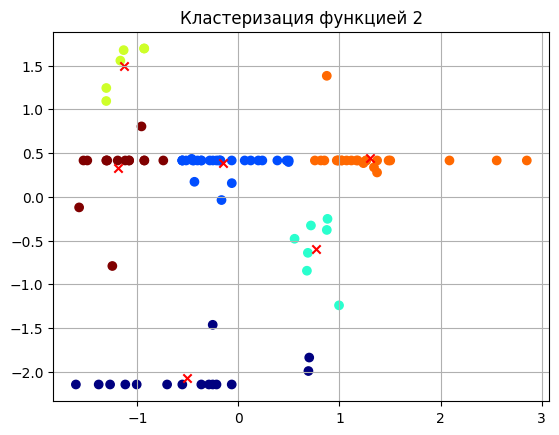

In [90]:
# Визуализация результатов первого варианта
plt.scatter(norm_values[:, 0], norm_values[:, 1], c=labels_1, cmap='jet')
plt.scatter(centroids_1[:, 0], centroids_1[:, 1], c='red', marker='x')
plt.title("Кластеризация функцией 1")
plt.grid()
plt.show()

plt.scatter(norm_values[:, 0], norm_values[:, 1], c=labels_2, cmap='jet')
plt.scatter(centroids_2[:, 0], centroids_2[:, 1], c='red', marker='x')
plt.title("Кластеризация функцией 2")
plt.grid()
plt.show()

### Пункт 6.

Результаты разбиения визуализированы на графиках, где точки, принадлежащие различным кластерам, выделены разными цветами. По ним видно что 2 алгоритма опредили примерно одинаковые кластеры. Это же вижно и по F метрикам. Также по нима видно, что алгоритм с обновлением цетроидов после изменений более быстро сходится.

## Выводы

В ходе выполнения работы были успешно нормализованы данные, что позволило привести их к единому масштабу для корректной работы алгоритма K-means. Грубая оценка количества кластеров была рассчитана по формуле, и полученное значение $\tilde k=6$ использовалось в дальнейшем анализе. Алгоритм K-means был реализован в двух вариантах: с пакетным обновлением центроидов после завершения просмотра всех данных и с онлайн-обновлением после каждого изменения состава кластера. Оба варианта продемонстрировали корректную работу и достижение сходимости, однако батч подход оказался более стабильным, в то время как  второй агоритм быстрее адаптировалось к изменениям. На каждом шаге процедуры вычислялись функционалы качества F1, F2, F3, которые подтвердили улучшение разбиения с увеличением числа итераций. Визуализация результатов показала четкое разделение данных на кластеры, где каждый кластер был выделен своим цветом, а центроиды отмечены красными крестами. Полученные кластеры можно интерпретировать как группы объектов с похожими характеристиками, что позволяет выявить скрытые закономерности в данных и использовать их для анализа поведения людей с разными уровнями веса и пищевых привычек.
